In [288]:
from __future__ import division, print_function

import GPy
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

from utilities import *

In [289]:
tau = 0.002

# x_min, x_max, accuracy
grid_param = [(-math.radians(30), math.radians(30), tau),
              (-1.5, 1.5, tau)]

extent = np.array([grid_param[0][0], grid_param[0][1], grid_param[1][0], grid_param[1][1]])

grid = [np.arange(*x) for x in grid_param]
num_samples = [len(x) for x in grid]
grid = combinations(grid)

print('Grid size: {0}'.format(len(grid)))

Grid size: 786000


In [367]:
n = 2
m = 1

mass = 0.1
friction = 0.
length = 0.5
gravity = 9.81

x_max = np.deg2rad(45)
u_max = gravity * mass * length * np.sin(x_max)
# u_max = np.deg2rad(45)
# x_max = np.rad2deg(np.arcsin(u_max / (mass * gravity * length)))

inertia = mass * length ** 2

A = np.array([[0, 1],
              [math.sqrt(gravity / length), -friction / inertia]])

B = np.array([[0],
              [1 / inertia]])

Q = np.array([[1, 0], [0, 0]], dtype=np.float)
R = np.array([[1]], dtype=np.float)

# x_n = inv(Tx) * x
Tx = np.diag([x_max, gravity / length * math.cos(x_max) * 0.1])
Tu = np.array([[u_max]])

Tx_inv = np.diag(np.diag(Tx)**(-1))
Tu_inv = np.diag(np.diag(Tu)**(-1))

Q = Tx_inv.T.dot(Q.dot(Tx_inv))
R = Tu_inv.T.dot(R.dot(Tu_inv))

Q *= np.array(1e-2, dtype=np.float)
R *= np.array(1e-2, dtype=np.float)


def ode(x, u):
    return np.hstack([x[:, [1]],
                      gravity / length * np.sin(x[:, [0]]) + u / inertia - friction / inertia * x[:, [1]]])

K, P = lqr(A, B, Q, R)

def control_law(x):
    u = -x.dot(K.T)
    u = np.clip(u, -0.2, 0.2)
    return u

def true_dynamics(x):
    x = np.asarray(x)
    u = control_law(x)
    return ode(x, u)

def prior_dynamics(x):
    x = np.asarray(x)
    u = control_law(x)
    return x.dot(A.T) + u.dot(B.T)

# Initial safe set
S0 = np.logical_and(np.abs(grid[:, 0]) < np.deg2rad(15),
                    np.abs(grid[:, 1]) < np.deg2rad(30))

if not np.any(S0):
    print('No initial safe points!')

In [369]:
np.sqrt(np.sum(extent[1:3]**2))

1.5887591629344071

#### Kernel definition

The inverted pendulum model is of the form
\begin{equation}
\ddot{\theta} = \frac{mgl \sin(\theta) + \tau}{m l^2}
\end{equation}

or, with the state vector $\mathbf{x} = [\mathbf{x}_1, \mathbf{x}_2] = [\theta, \dot{\theta}]$, the dynamics are
\begin{equation}
\dot{\mathbf{x}} =
\left[
\begin{matrix}
\mathbf{x}_2 \\
\frac{mgl \sin(\mathbf{x}_1) + \tau}{m l^2}
\end{matrix} \right]
\end{equation}

The first part of this equation says that the angle is equal to the integrated angular velocity. This is a intuitively true, irrespective of model errors. As such, we only train a model on the second part of the dynamics. That is
\begin{equation}
\dot{\mathbf{x}} =
\left[
\begin{matrix}
\mathbf{x}_2 \\
\frac{mgl \sin(\mathbf{x}_1) + \tau}{m l^2} + g_\pi(\mathbf{x})
\end{matrix} \right]
\end{equation}


In [370]:
mf = GPy.core.Mapping(2, 1)
mf.f = lambda x: prior_dynamics(x)[:, [1]]
mf.update_gradients = lambda a,b: None

x_lin_max = np.max(np.abs(prior_dynamics(grid) - true_dynamics(grid)))
kernel = (GPy.kern.RBF(input_dim=2, lengthscale=0.5, variance=40**2, ARD=True, name='rbf') *
          GPy.kern.Linear(input_dim=2, name='linear', variances=1/x_lin_max))
likelihood = GPy.likelihoods.Gaussian(variance=0.01**2)
gp = GPy.core.GP(np.array([[0, 0]]), np.array([[0]]), kernel, likelihood, mean_function=mf)

def predict_model(gp, x):
    gp_mean, gp_var = gp._raw_predict(x)
    gp_mean = np.hstack([x[:, [1]], gp_mean])
    gp_var = np.hstack([np.zeros_like(gp_var), gp_var])
    return gp_mean, gp_var

L = 0

In [371]:
# Lyapunov function:
V, dV = quadratic_lyapunov_function(grid, P)
V_max = np.max(V)
accuracy = V_max / 1e10

# Lipschitz constants of Lyapunov function
B_dV = L_V = np.max(np.abs(dV), axis=1)

kernel_lengthscale = np.min(gp.kern.rbf.lengthscale).squeeze().tolist()
kernel_var = gp.kern.rbf.variance.values.squeeze().tolist()

# Dynamics Lipschitz constants
L_g = np.sqrt(kernel_var) / kernel_lengthscale * gp.kern.linear.Kdiag(grid)
L_f = max(np.max(A), np.max(B))

# Function bounds
B_g = np.sqrt(kernel_var) * gp.kern.linear.Kdiag(grid)
# B_f = np.max(prior_dynamics(grid))
B_f = prior_dynamics(grid)[:, 1]

B_true = np.max(true_dynamics(grid), axis=1)

L = (B_g + B_f) * L_V + B_dV * (L_g + L_f)
L_true = B_true * L_V + B_dV * L_f

In [372]:
dV.shape

(786000, 2)

In [373]:
np.max(L)

0.87807495587817797

[ 0.87807496  0.87669081  0.87530887 ...,  0.75685093  0.75817562
  0.75950251] [ 0.39255706  0.3923963   0.39223551 ...,  0.42487208  0.4250687
  0.42526533]


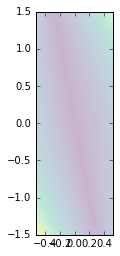

In [374]:
print(L, L_true)
plt.imshow(np.reshape(L, num_samples).T, extent=extent, origin='lower', alpha=0.3, cmap='viridis')

## True safe levelset

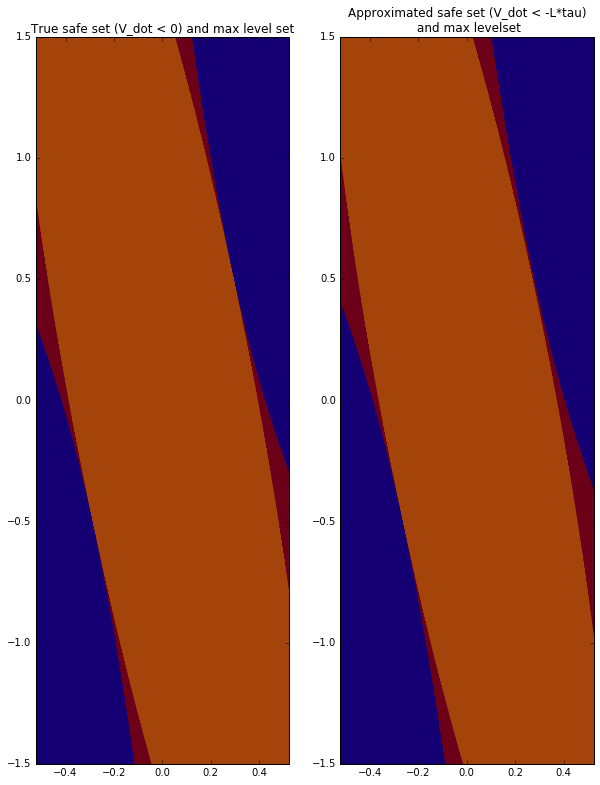

Number of safe points: 572174/786000


In [375]:
V_dot_true = compute_v_dot(dV, true_dynamics(grid))

fig, axes = plt.subplots(1, 2, figsize=(10, 20))

S = get_safe_set(V_dot_true, 0, S0=None)
axes[0].imshow(np.reshape(S, num_samples).T, extent=extent, origin='lower')
c = find_max_levelset(S, V, accuracy)
axes[0].imshow(np.reshape(V <= c, num_samples).T, extent=extent, origin='lower', alpha=0.3, cmap='viridis')
axes[0].set_title('True safe set (V_dot < 0) and max level set')

S2 = get_safe_set(V_dot_true, -L*tau, S0=S0)
c = find_max_levelset(S2, V, accuracy)
axes[1].imshow(np.reshape(S2, num_samples).T, extent=extent, origin='lower')
axes[1].set_title('Approximated safe set (V_dot < -L*tau)\n and max levelset')
axes[1].imshow(np.reshape(V < c, num_samples).T, extent=extent, origin='lower', alpha=0.3, cmap='viridis')
plt.show()

print('Number of safe points: {0}/{1}'.format(np.count_nonzero(S), grid.shape[0]))

## Online learning

In [376]:
V, dV = quadratic_lyapunov_function(grid, P)
    
def update_gp():
    dynamics_mean, dynamics_var = predict_model(gp, grid)
    V_dot = compute_v_dot(dV, dynamics_mean, dynamics_var, beta=2.)
    S = get_safe_set(V_dot, -L*tau, S0=S0)
    c = find_max_levelset(S, V, accuracy)
    S[:] = V <= c
    max_id = np.argmax(dynamics_var[S, 1])
    max_state = grid[S][[max_id], :].copy()
    gp.set_XY(np.vstack([gp.X, max_state]),
              np.vstack([gp.Y, true_dynamics(max_state)[:, [1]]]))
    return S

In [388]:
for i in range(10):
    update_gp()
S = update_gp()
print(np.count_nonzero(S))

243505


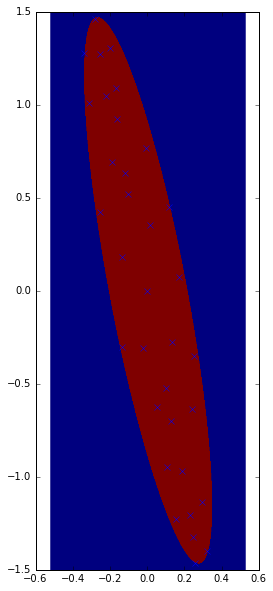

In [389]:
fig = plt.figure(figsize=(10, 10))
c = plt.imshow(np.reshape(S, num_samples).T, extent=extent, origin='lower')
# c = plt.imshow(np.reshape(V_dot, num_samples).T < 0, extent=extent, origin='lower', cmap='viridis')
# plt.colorbar(c)
plt.plot(gp.X[:, 0], gp.X[:, 1], 'x')

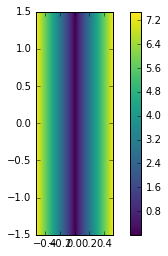

In [379]:
error = np.abs(true_dynamics(grid)[:, 1] - prior_dynamics(grid)[:, 1])
c = plt.imshow(np.reshape(error, num_samples).T, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(c)

In [380]:
gp.set_XY(np.array([[0, 0]]),
          np.array([[0]]))

mean, var = gp._raw_predict(grid)

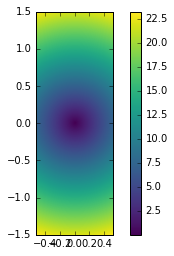

In [381]:
c = plt.imshow(np.reshape(np.sqrt(var), num_samples).T, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(c)

In [382]:
gp.kern.linear

linear.,Value,Constraint,Prior,Tied to
variances,0.133498034003,+ve,,


In [383]:
kern = GPy.kern.Poly(2)

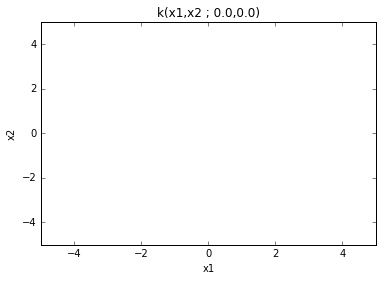

In [384]:
kern.plot()